In [1]:
# # Mount to Google Drive to train on Colab
from google.colab import drive
drive.mount('/content/drive')
%cd  /content/drive/'My Drive'/"SP22_ML_final_project"/

Mounted at /content/drive
/content/drive/My Drive/SP22_ML_final_project


In [2]:
import os
import xml.etree.ElementTree as ET

from PIL import Image
from tqdm import tqdm

from yolo import YOLO
from utils.utils import get_classes
from utils.utils_map import get_coco_map, get_map

Load model.
logs/ep056-loss2.742-val_loss2.436.pth model, and classes loaded.
Load model done.
Get predict result.


  0%|          | 0/86 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
100%|██████████| 86/86 [00:58<00:00,  1.47it/s]


Get predict result done.
Get ground truth result.


100%|██████████| 86/86 [00:52<00:00,  1.63it/s]


Get ground truth result done.
Get map.
0.00% = mask_weared_incorrect AP 	||	score_threhold=0.5 : F1=0.00 ; Recall=0.00% ; Precision=0.00%
94.66% = with_mask AP 	||	score_threhold=0.5 : F1=0.91 ; Recall=92.98% ; Precision=89.64%
87.92% = without_mask AP 	||	score_threhold=0.5 : F1=0.82 ; Recall=72.82% ; Precision=94.94%
mAP = 60.86%


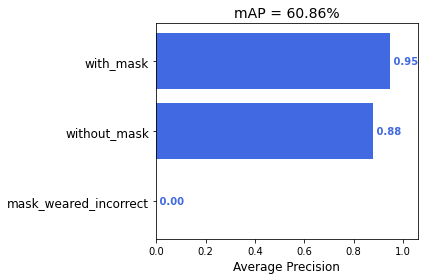

Get map done.


In [3]:
'''
Recall和Precision不像AP是一个面积的概念，在门限值不同时，网络的Recall和Precision值是不同的。
map计算结果中的Recall和Precision代表的是当预测时，门限置信度为0.5时，所对应的Recall和Precision值。
此处获得的./map_out/detection-results/里面的txt的框的数量会比直接predict多一些，这是因为这里的门限低，
目的是为了计算不同门限条件下的Recall和Precision值，从而实现map的计算。
'''
#------------------------------------------------------------------------------------------------------------------#
#   map_mode用于指定该文件运行时计算的内容
#   map_mode为0代表整个map计算流程，包括获得预测结果、获得真实框、计算VOC_map。
#   map_mode为1代表仅仅获得预测结果。
#   map_mode为2代表仅仅获得真实框。
#   map_mode为3代表仅仅计算VOC_map。
#   map_mode为4代表利用COCO工具箱计算当前数据集的0.50:0.95map。需要获得预测结果、获得真实框后并安装pycocotools才行
#-------------------------------------------------------------------------------------------------------------------#
map_mode        = 0
#-------------------------------------------------------#
#   此处的classes_path用于指定需要测量VOC_map的类别
#   一般情况下与训练和预测所用的classes_path一致即可
#-------------------------------------------------------#
classes_path    = 'model_data/facemask_classes.txt'
#-------------------------------------------------------#
#   MINOVERLAP用于指定想要获得的mAP0.x
#   比如计算mAP0.75，可以设定MINOVERLAP = 0.75。
#-------------------------------------------------------#
MINOVERLAP      = 0.5
#-------------------------------------------------------#
#   map_vis用于指定是否开启VOC_map计算的可视化
#-------------------------------------------------------#
map_vis         = False
#-------------------------------------------------------#
#   指向VOC数据集所在的文件夹
#   默认指向根目录下的VOC数据集
#-------------------------------------------------------#
VOCdevkit_path  = 'VOCdevkit'
#-------------------------------------------------------#
#   结果输出的文件夹，默认为map_out
#-------------------------------------------------------#
map_out_path    = 'map_out'

image_ids = open(os.path.join(VOCdevkit_path, "VOC2007/ImageSets/Main/test.txt")).read().strip().split()

if not os.path.exists(map_out_path):
    os.makedirs(map_out_path)
if not os.path.exists(os.path.join(map_out_path, 'ground-truth')):
    os.makedirs(os.path.join(map_out_path, 'ground-truth'))
if not os.path.exists(os.path.join(map_out_path, 'detection-results')):
    os.makedirs(os.path.join(map_out_path, 'detection-results'))
if not os.path.exists(os.path.join(map_out_path, 'images-optional')):
    os.makedirs(os.path.join(map_out_path, 'images-optional'))

class_names, _ = get_classes(classes_path)

if map_mode == 0 or map_mode == 1:
    print("Load model.")
    yolo = YOLO(confidence = 0.001, nms_iou = 0.65)
    print("Load model done.")

    print("Get predict result.")
    for image_id in tqdm(image_ids):
        image_path  = os.path.join(VOCdevkit_path, "VOC2007/JPEGImages/"+image_id+".jpg")
        image       = Image.open(image_path)
        if map_vis:
            image.save(os.path.join(map_out_path, "images-optional/" + image_id + ".jpg"))
        yolo.get_map_txt(image_id, image, class_names, map_out_path)
    print("Get predict result done.")
    
if map_mode == 0 or map_mode == 2:
    print("Get ground truth result.")
    for image_id in tqdm(image_ids):
        with open(os.path.join(map_out_path, "ground-truth/"+image_id+".txt"), "w") as new_f:
            root = ET.parse(os.path.join(VOCdevkit_path, "VOC2007/Annotations/"+image_id+".xml")).getroot()
            for obj in root.findall('object'):
                difficult_flag = False
                if obj.find('difficult')!=None:
                    difficult = obj.find('difficult').text
                    if int(difficult)==1:
                        difficult_flag = True
                obj_name = obj.find('name').text
                if obj_name not in class_names:
                    continue
                bndbox  = obj.find('bndbox')
                left    = bndbox.find('xmin').text
                top     = bndbox.find('ymin').text
                right   = bndbox.find('xmax').text
                bottom  = bndbox.find('ymax').text

                if difficult_flag:
                    new_f.write("%s %s %s %s %s difficult\n" % (obj_name, left, top, right, bottom))
                else:
                    new_f.write("%s %s %s %s %s\n" % (obj_name, left, top, right, bottom))
    print("Get ground truth result done.")

if map_mode == 0 or map_mode == 3:
    print("Get map.")
    get_map(MINOVERLAP, True, path = map_out_path)
    print("Get map done.")

if map_mode == 4:
    print("Get map.")
    get_coco_map(class_names = class_names, path = map_out_path)
    print("Get map done.")